## Extract FLASH Data in yt
Mirielle Wong

6/21/24

Use yt's covering_grid class to extract data from FLASH.

In [2]:
# https://yt-project.org/

import yt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# plot_path = "./OSIRIS_transfer/MAGOFF/MagShockZ_hdf5_plt_cnt_0004"
plot_path = "~/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

In [4]:
ds = yt.load(plot_path)

yt : [INFO     ] 2024-09-18 16:58:47,423 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-09-18 16:58:47,485 Parameters: current_time              = 1.8520020414484505e-09
yt : [INFO     ] 2024-09-18 16:58:47,485 Parameters: domain_dimensions         = [288 272 288]
yt : [INFO     ] 2024-09-18 16:58:47,486 Parameters: domain_left_edge          = [-0.6   -0.075 -0.6  ]
yt : [INFO     ] 2024-09-18 16:58:47,486 Parameters: domain_right_edge         = [0.6 1.  0.6]
yt : [INFO     ] 2024-09-18 16:58:47,486 Parameters: cosmological_simulation   = 0


In [5]:
# this is from the yt documentation

level = 2
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=[-0.6, -0.075, -0.6],
    dims=dims,
    # And any fields to preload (this is optional!)
)
print(type(all_data))   

<class 'yt.data_objects.construction_data_containers.YTCoveringGrid'>


In [6]:
def save_slice(normalizations:dict, target_index=84): # gonna try the forbidden technique of using all_data as a global variable
    z_middle_index = dims[2] // 2
    ne_cgs = 5e18 # [cm^-3]
    e = 4.80320425e-10 # [statC] = [cm^3/2⋅g^1/2⋅s^−1]
    m_e = 9.1093837139e-28 # [g].
    c = 2.99792458e10 # [cm/s]
    omega_pe = np.sqrt(4*np.pi*ne_cgs*e**2/m_e)
    x = all_data['flash','x'][:,0,0]*omega_pe/c
    y = all_data['flash','y'][0,target_index:,0]*omega_pe/c
    import os
    if not os.path.exists("interp"):
        os.makedirs("interp")

    from scipy.interpolate import RegularGridInterpolator
    import pickle
    
    for field in normalizations.keys():
        field_data = np.array(all_data['flash', field][:, target_index:, z_middle_index])/normalizations[field]
        interp1 = RegularGridInterpolator( (y, x), field_data.T, method='cubic', bounds_error=False, fill_value=0 )
        with open(f"interp/{field}-interp.pkl", "wb") as f:
            pickle.dump(interp1, f)

Now, we must construct the fields that we will use directly by OSIRIS.
This raises a question, do we convert everything to OSIRIS units now or do we write it out to the hard drive first and then convert after?

In [7]:
# Add appropriate fields

# perform appropriate conversions to get the number density of ions and electrons

def make_ion_number_density(field, data):
    avogadro = 6.022e23
    ion_number_density = avogadro*data["flash","dens"]*data["flash","sumy"]
    return ion_number_density

def make_electron_number_density(field, data):
    avogadro = 6.022e23
    electron_number_density = avogadro*data["flash","dens"]*data["flash","ye"]
    return electron_number_density

ds.add_field(("flash", "idens"), function=make_ion_number_density, units="code_mass/code_length**3",sampling_type="cell") # technically the units are wrong here, should be massless
ds.add_field(("flash", "edens"), function=make_electron_number_density, units="code_mass/code_length**3",sampling_type="cell") # same here

aluminum_molecular_weight = 26.981 # from wikipedia
al_r = 1/aluminum_molecular_weight # reciprocal molecular weight, needs to be same units as sumy
magnesium_molecular_weight = 24.305 # from wikipedia
mg_r = 1/magnesium_molecular_weight # reciprocal molecular weight

def make_magnesium_number_density(field, data):
    mg_percentage = (data["flash","sumy"]-al_r)/(mg_r-al_r)
    mg_number_density = mg_percentage*data["flash","edens"] # we did this because Zbar is ye/sumy, so we can just use edens instead to get the number density in units that are useful to osiris
    return mg_number_density

def make_aluminum_number_density(field, data):
    mg_percentage = (data["flash","sumy"]-al_r)/(mg_r-al_r)
    al_number_density = (1-mg_percentage)*data["flash","edens"]
    return al_number_density

ds.add_field(("flash", "mgdens"), function=make_magnesium_number_density, units="code_mass/code_length**3",sampling_type="cell", force_override=True) # technically the units are wrong here, should be massless
ds.add_field(("flash", "aldens"), function=make_aluminum_number_density, units="code_mass/code_length**3",sampling_type="cell",force_override=True)

In [8]:
def make_Ex(field, data):
    Ex = data['flash','velz']*data["flash","magy"]-data["flash","vely"]*data["flash","magz"]
    return Ex

def make_Ey(field, data):
    Ey = data['flash','velx']*data["flash","magz"]-data["flash","velz"]*data["flash","magx"]
    return Ey

def make_Ez(field, data):
    Ez = data['flash','vely']*data["flash","magx"]-data["flash","velx"]*data["flash","magy"]
    return Ez

ds.add_field(("flash", "Ex"), function=make_Ex, units="code_magnetic*code_length/code_time",sampling_type="cell")
ds.add_field(("flash", "Ey"), function=make_Ey, units="code_magnetic*code_length/code_time",sampling_type="cell")
ds.add_field(("flash", "Ez"), function=make_Ez, units="code_magnetic*code_length/code_time",sampling_type="cell")

In [9]:
u = ds.units
rqm = 100 # [m_e]
ne_cgs = 5e18 # [cm^-3]
e = 4.80320425e-10 # [statC] = [cm^3/2⋅g^1/2⋅s^−1]
m_e = 9.1093837139e-28 # [g].
c = 2.99792458e10 # [cm/s]
kb = 8.617333262e-5 # [eV/K]
omega_pe = np.sqrt(4*np.pi*ne_cgs*e**2/m_e)
proton_mass = 1.6726219e-24 # [g]
B = 150000 # [Gauss]
T_e = 40 # [eV]
Al_charge_state = 6
rho_0 = aluminum_molecular_weight*proton_mass*ne_cgs/Al_charge_state
alfven_speed = B/np.sqrt(4*np.pi*rho_0) # check this factor of 4pi
print(alfven_speed)
print(B/((omega_pe*m_e*c)/e))
alfven_speed_osiris = B/((omega_pe*m_e*c)/e)*1/np.sqrt(1*rqm) # Check that this is unitless
print(alfven_speed_osiris)
v_th = np.sqrt(T_e/kb/m_e)


normalizations = {
    # 'aldens':ne_cgs, # check this normalization
    # 'edens':ne_cgs,
    # 'mgdens':ne_cgs,
    # 'magx':(omega_pe*m_e*c)/e,
    # 'magy':(omega_pe*m_e*c)/e,
    # 'magz':(omega_pe*m_e*c)/e,
    # 'Ex':(omega_pe*m_e*c**2)/e,
    # 'Ey':(omega_pe*m_e*c**2)/e, 
    # 'Ez':(omega_pe*m_e*c**2)/e,
    # 'x':c/omega_pe,
    # 'y':c/omega_pe,
}
save_slice(normalizations)

6899999.189107501
0.020913952814540445
0.0020913952814540443


In [11]:
def make_vth_ele(field, data):
    return np.sqrt(data['flash','tele']*u.kb_cgs/u.electron_mass_cgs)

def make_vth_ion(field, data):
    return np.sqrt(data['flash','tion']*u.kb_cgs/(u.electron_mass_cgs*rqm))

ds.add_field(("flash", 'vthele'), function=make_vth_ele, units="code_velocity",sampling_type="cell",force_override=True)
ds.add_field(("flash", 'vthion'), function=make_vth_ion, units="code_velocity",sampling_type="cell",force_override=True)

In [15]:
normalizations = {
    'velx':alfven_speed/alfven_speed_osiris,
    'vely':alfven_speed/alfven_speed_osiris,
    'velz':alfven_speed/alfven_speed_osiris,
    # 'vthele':c,
    'vthion':c,
}
save_slice(normalizations)

Value at point: [3.73001763e-05 3.73001763e-05 3.73001763e-05 ... 3.73016274e-05
 3.73016274e-05 3.73016274e-05] code_mass/code_length**3


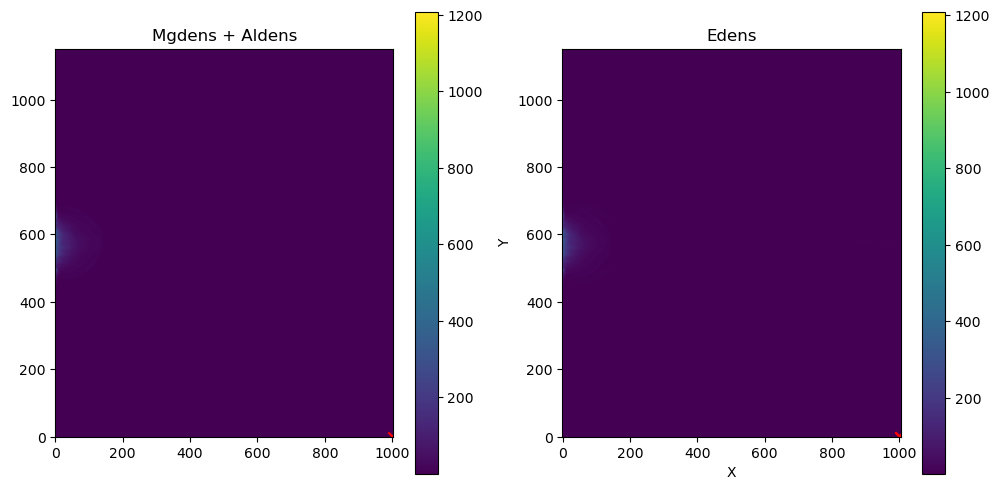

In [16]:
import yt
# mgdens = np.load("FLASH-slices/mgdens.npy")
edens = np.load("FLASH-slices/edens.npy")
aldens = np.load("FLASH-slices/aldens.npy")
mgdens = np.load("FLASH-slices/mgdens.npy")

point_y=3; point_x=1000  # Replace point_y and point_x with the desired coordinates
value = all_data['dens'][point_y, point_x]  # Replace point_y and point_x with the desired coordinates
print("Value at point:", value)

# Add indication on the plot where the point is

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(mgdens, origin='lower')
ax1.scatter(point_x, point_y, color='red', marker='x')
ax1.set_title('Mgdens + Aldens')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(edens, origin='lower')
ax2.scatter(point_x, point_y, color='red', marker='x')
ax2.set_title('Edens')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
fig.colorbar(im2, ax=ax2)
plt.scatter(point_x, point_y, color='red', marker='x')

plt.show()
# im.set_clim(0, 200)


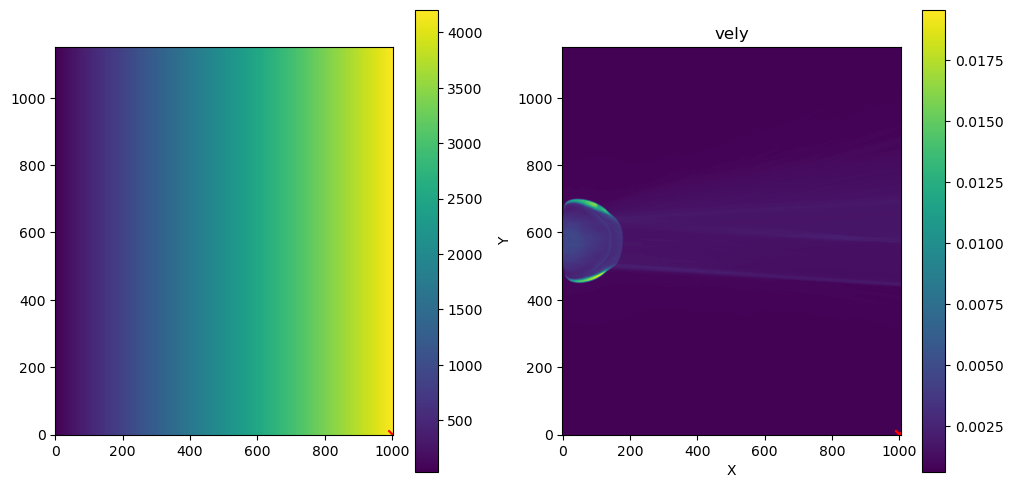

In [17]:
velx = np.load("FLASH-slices/y.npy")
vely = np.load("FLASH-slices/vthion.npy")
velz = np.load("FLASH-slices/velz.npy")

point_y=3; point_x=1000  # Replace point_y and point_x with the desired coordinates
# value = all_data['dens'][point_y, point_x]  # Replace point_y and point_x with the desired coordinates
# print("Value at point:", value)

# Add indication on the plot where the point is

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(velx, origin='lower')
ax1.scatter(point_x, point_y, color='red', marker='x')
ax1.set_title('')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(vely, origin='lower')
ax2.scatter(point_x, point_y, color='red', marker='x')
ax2.set_title('vely')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
fig.colorbar(im2, ax=ax2)
plt.scatter(point_x, point_y, color='red', marker='x')

plt.show()
# im.set_clim(0, 200)


In [18]:
x = np.load("FLASH-slices/x.npy")
print(f"Bounds of simulation in osiris units: x {round(x.min(),0)},{round(x.max(),0)}")
y = np.load("FLASH-slices/y.npy")
print(f"Bounds of simulation in osiris units: y {round(y.min(),0)},{round(y.max(),0)}")

Bounds of simulation in osiris units: x -2522.0,2522.0
Bounds of simulation in osiris units: y 36.0,4206.0


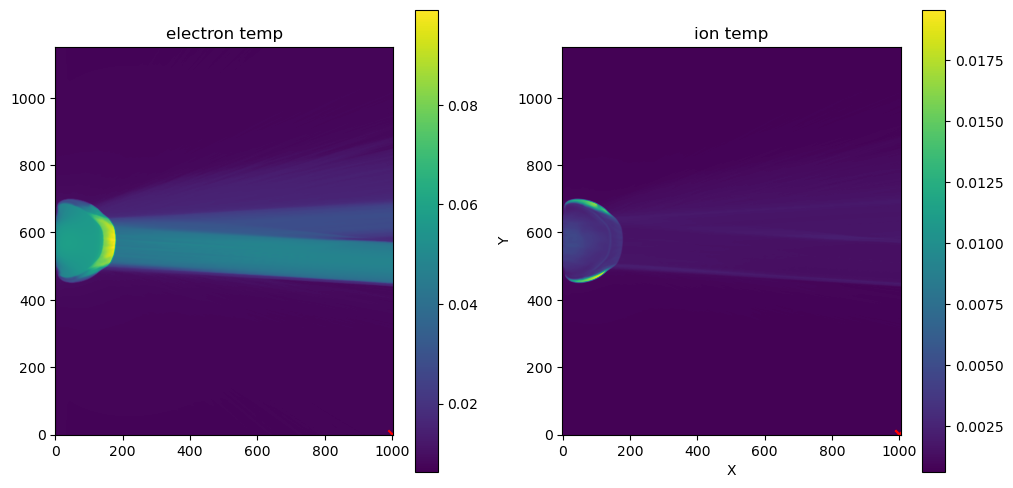

In [19]:
vthele = np.load("FLASH-slices/vthele.npy")
vthion = np.load("FLASH-slices/vthion.npy")
# velz = np.load("FLASH-slices/velz.npy")

point_y=3; point_x=1000  # Replace point_y and point_x with the desired coordinates
# value = all_data['dens'][point_y, point_x]  # Replace point_y and point_x with the desired coordinates
# print("Value at point:", value)

# Add indication on the plot where the point is

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(vthele, origin='lower')
ax1.scatter(point_x, point_y, color='red', marker='x')
ax1.set_title('electron temp')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(vthion, origin='lower')
ax2.scatter(point_x, point_y, color='red', marker='x')
ax2.set_title('ion temp')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
fig.colorbar(im2, ax=ax2)
plt.scatter(point_x, point_y, color='red', marker='x')

plt.show()
# im.set_clim(0, 200)


In [20]:
x = np.load("FLASH-slices/x.npy")[:,0]
y = np.load("FLASH-slices/y.npy")[0]

# nx = STATE["data"].shape
# x1 = np.linspace( x_bnd[0,0], x_bnd[0,1], nx[1], endpoint=True )
# x2 = np.linspace( x_bnd[1,0], x_bnd[1,1], nx[0], endpoint=True )
# X1, X2 = np.meshgrid( x1, x2, indexing='xy' ) # Matches Fortran array indexing
from scipy.interpolate import RegularGridInterpolator
func = RegularGridInterpolator((x, y), np.load("FLASH-slices/vthele.npy"), bounds_error=False, fill_value=0)
x1 = np.linspace(x.min(), x.max(), 5022)
print(x1)
x2 = np.linspace(y.min(), y.max(), 4206)
xnew, ynew = np.meshgrid(x1, x2, indexing='xy')

points_new = np.array([xnew.flatten(), ynew.flatten()]).T

# synthetic = func(points_new)
# # synthetic = synthetic.reshape((4206, 5022))
# plt.imshow(synthetic, origin='lower')

[-2522.49249572 -2521.48771879 -2520.48294185 ...  2520.48294185
  2521.48771879  2522.49249572]


In [ ]:
write_interp_to_file("FLASH-slices/vthele.npy")


# vthele = np.load("FLASH-slices/vthele.npy")
# print(vthele)

(1152, 1004)
(1152,)
(1004,)
